In [1]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from imexam.imexamine import Imexamine
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

Ginga not installed, use other viewer, or no viewer


In [2]:
# grab show_image
phot_tutorial_dir = '/Users/polinapetrov/F21/ASTR8060/phot_tutorial/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [22]:
# define directories
reduced_dir = '/Users/polinapetrov/F21/ASTR8060/reduced_2/' # working directory

def get_phot(file,approx_pos):
    #print(file)
    '''
    This function takes an input file, list of positions for stars to find, and plot title.
    
    It executes the following steps:
    1. Read in the data.
    2. Find all sources in the image. It assumes the FWHM is approximately 4 pix and finds everything greater than 10 sigma.
    3. It collects the info for the sources given in the input position list, matching within 10 pixel positions.
    4. It puts r=10pix apertures on each of these stars, as well as r_in=15, r_out=20 background annuli.
    5. It calculates background-subtracted instrumental magnitudes.
    6. It plots the image and apertures for visual inspection.
    7. It returns a table of photometry.
    '''
    fwhm       = 4.0
    source_snr = 10

    sci        = CCDData.read(file,unit='adu')
    data       = sci.data
    hdr        = sci.header
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)    
    sources = daofind(data)
    
    positions = np.zeros_like(approx_pos)
    for position,i in zip(approx_pos,range(np.shape(approx_pos)[0])):
        #print(position)
        #print('')
        match = np.where((abs(sources['xcentroid']-position[0])<10) & (abs(sources['ycentroid']-position[1])<10))[0][0]
        positions[i] = (sources['xcentroid'][match],sources['ycentroid'][match])
          
    # photometry
    # biggest FWHM is 4.2 pix
    aperture  = CircularAperture(positions, r=4)
    phot = aperture_photometry(data, aperture)
    for col in phot.colnames:
        phot[col].info.format = '%.8g'              # for consistent table output
        
    # calculate the mean background
    # note that for PG1633+099, this will include two little stars :(
    annulus_aperture = CircularAnnulus(positions, r_in=15., r_out=20.)
    bg   = aperture_photometry(data,annulus_aperture)
    for col in bg.colnames:
        bg[col].info.format = '%.8g'                # for consistent table output
    msky = bg['aperture_sum']/annulus_aperture.area # get bg cts/pixel
    
    phot['inst_mag'] = -2.5 * np.log10(phot.columns['aperture_sum']-msky*aperture.area)
      
    # show the image with apertures
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #show_image(data, cmap='gray', ax=ax, fig=fig)
    #aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
    #annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
    #ax.set_xlim([800,1500])
    #ax.set_ylim([800,1500])
    #plt.title(title)
    #plt.tight_layout()
    #plt.show()
    
    return phot

# Q3

Using the extinction terms and color terms derived for the imaging dataset previously, do photometry on the stars in NGC6823 and make a color magnitude diagram of this open cluster and compare it to a published one. Either V vs. B−V or R vs. R−I are the most common ones you might find, but there may be others. Assess in a paragraph semi-quantitatively how well does your data agree with published data? Note that your data may be affected by interstellar extinction, so you may need to deredden your data to better match the published CMD, if the published CMD has been corrected already. Use a paper such as Cardelli, Clayton, & Mathis (1989) to do the dereddening.

In [17]:
#choosing one V frame
V_file = reduced_dir+'a157otzf.fits'
V_data = fits.open(V_file)[0].data

mean, median, std = sigma_clipped_stats(V_data, sigma=3.0)
daofind = DAOStarFinder(fwhm=4.0, threshold=100.*std) #getting some smaller subset of stars in the frame
V_sources = daofind(V_data - median)
for col in V_sources.colnames:
    V_sources[col].info.format = '%.8g'

In [18]:
V_sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,860.42193,90.255658,0.41393178,-0.42771724,-0.92567796,25,0,1192.5587,1.3821639,-0.35139884
2,1230.6236,97.086993,0.46106965,-0.71450556,-0.98299785,25,0,18257.825,18.857733,-3.1887237
3,1052.5423,109.8881,0.50837967,-0.72545769,-0.83221225,25,0,9092.5034,9.2278523,-2.4127516
4,600.69058,122.95578,0.4357272,-0.74440514,-0.79089097,25,0,950.29205,1.0778565,-0.081402394
5,431.63592,233.37404,0.45030258,-0.86456124,-0.83254979,25,0,8131.8042,8.4479837,-2.3168827
6,52.64376,279.28244,0.48237074,-0.82443597,-0.8225268,25,0,1765.2101,1.8425858,-0.66356931
7,1114.236,297.47157,0.46103586,-0.41593911,-0.78477472,25,0,1249.4474,1.2122353,-0.20896728
8,577.23701,359.87836,0.46065642,-0.56550149,-0.85846932,25,0,1658.9856,1.8843996,-0.68793251
9,815.22639,367.42875,0.5306449,-0.4259321,-0.57004138,25,0,1185.582,1.0986089,-0.10210774


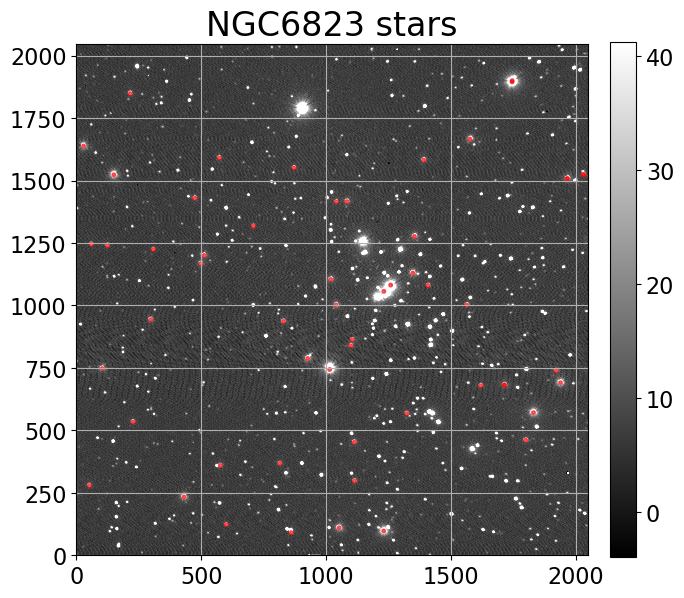

In [62]:
V_positions = [(x,y) for x,y in zip(V_sources['xcentroid'],V_sources['ycentroid'])]
V_apertures = [CircularAperture(p, r=4) for p in V_positions]

#plotting apertures
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
show_image(V_data, cmap='gray', ax=ax1, fig=fig)
for a in V_apertures:
    a.plot(color='red', lw=2, alpha=0.75)
ax1.set_title('NGC6823 stars')
plt.tight_layout()

In [20]:
#choosing one B frame
B_file = reduced_dir+'a160otzf.fits'
B_data = fits.open(B_file)[0].data

mean, median, std = sigma_clipped_stats(B_data, sigma=3.0)
daofind = DAOStarFinder(fwhm=4.0, threshold=100.*std) #getting some smaller subset of stars in the frame
B_sources = daofind(B_data - median)
for col in B_sources.colnames:
    B_sources[col].info.format = '%.8g'
    
B_sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,167.25471,35.687541,0.48040963,-0.66830029,-0.75430616,25,0,2989.0172,2.0382905,-0.77316521
2,1229.7905,95.548276,0.46055676,-0.76008027,-0.41793788,25,0,65789.62,38.641876,-3.9676455
3,1228.4116,96.076642,0.37224375,-0.14915752,-0.66196133,25,0,65526.843,40.617482,-4.0217825
4,1222.5669,97.721802,0.58001523,0.30199846,-0.70737899,25,0,16805.682,7.3185982,-2.1610698
5,1627.0073,99.818949,0.51870591,-0.85592068,-0.86988529,25,0,1555.3226,1.0348308,-0.037173346
6,1229.9745,102.55271,0.47464751,-0.18464035,0.46599913,25,0,6564.7071,2.8126676,-1.122796
7,1050.4158,108.77006,0.45207292,-0.79299685,-0.93667772,25,0,53689.19,36.833243,-3.9155999
8,1246.6817,109.64016,0.42402987,-0.80912372,-0.94578251,25,0,3927.6763,2.6886977,-1.0738549
9,1044.5805,110.39331,0.56622384,0.44954797,-0.83733635,25,0,9341.9557,3.9148201,-1.4817795


In [33]:
#photometry for V frame
V_pos = [(x,y) for x,y in zip(V_sources['xcentroid'],V_sources['ycentroid'])]

V_apertures  = CircularAperture(V_pos, r=4)
V_phots = aperture_photometry(V_data, V_apertures)
for col in V_phots.colnames:
    V_phots[col].info.format = '%.8g' 
    
annulus_aperture = CircularAnnulus(V_pos, r_in=15., r_out=20.)
bg   = aperture_photometry(V_data,annulus_aperture)
for col in bg.colnames:
    bg[col].info.format = '%.8g'                
msky = bg['aperture_sum']/annulus_aperture.area
V_phots['inst_mag'] = -2.5 * np.log10(V_phots.columns['aperture_sum']-msky*V_apertures.area)

In [51]:
#photometry for B frame
B_pos = np.zeros_like(V_pos)
for position,i in zip(V_pos,range(np.shape(V_pos)[0])):
    match = np.where((abs(B_sources['xcentroid']-position[0])<10) & (abs(B_sources['ycentroid']-position[1])<10))[0]
    if len(match)>1:
        match = match[0]
        B_pos[i] = (B_sources['xcentroid'][match],B_sources['ycentroid'][match])
    elif len(match) != 0:
        B_pos[i] = (B_sources['xcentroid'][match],B_sources['ycentroid'][match])
        
B_apertures  = CircularAperture(B_pos, r=4)
B_phots = aperture_photometry(B_data, B_apertures)
for col in B_phots.colnames:
    B_phots[col].info.format = '%.8g'

annulus_aperture = CircularAnnulus(B_pos, r_in=15., r_out=20.)
bg   = aperture_photometry(B_data,annulus_aperture)
for col in bg.colnames:
    bg[col].info.format = '%.8g'                
msky = bg['aperture_sum']/annulus_aperture.area
B_phots['inst_mag'] = -2.5 * np.log10(B_phots.columns['aperture_sum']-msky*B_apertures.area)

/Users/polinapetrov/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  


In [56]:
#from Part 1:
B_ext = 0.3226764233838469
V_ext = 0.46506980368682843
B_tr = 1.1151336134376857
V_tr = 0.17712252162822534
B_zp = 28.630439289610937
V_zp = 27.88597734273399

B_airmass = 1.09
V_airmass = 1.10

Text(0.5, 1.0, 'Color Magnitude Diagram for NGC6823')

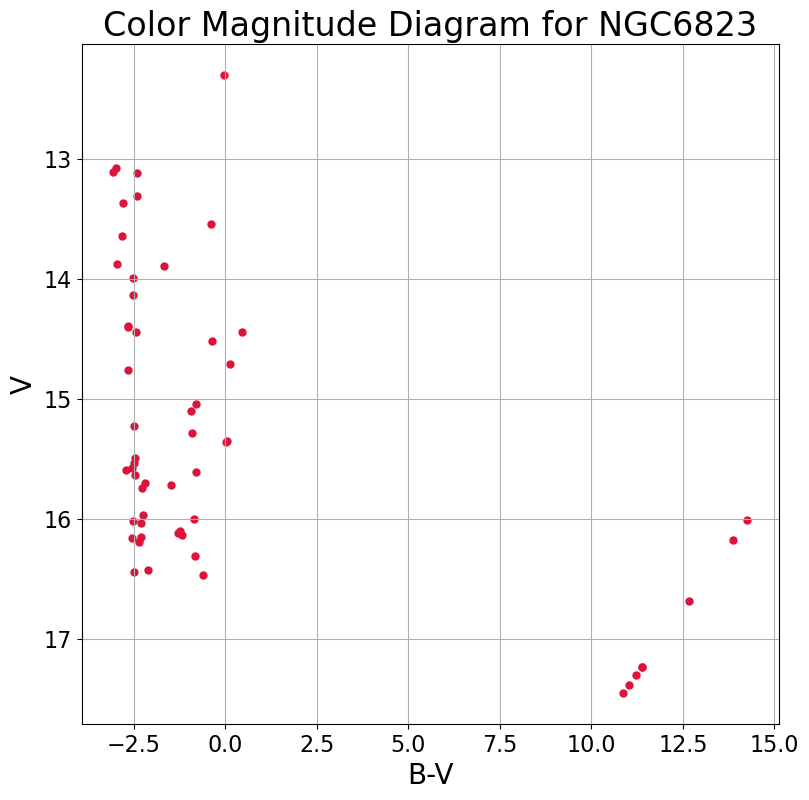

In [61]:
#plotting CMD
fig = plt.figure(1, figsize=(9,9))
for i in range(0,len(V_phots)):
    B_inst = B_phots[i]['inst_mag'] - B_ext*B_airmass
    V_inst = V_phots[i]['inst_mag'] - V_ext*V_airmass
    B_mag = B_inst + B_zp + B_tr*(B_inst-V_inst)
    V_mag = V_inst + V_zp + V_tr*(B_inst-V_inst)
    plt.scatter(B_mag-V_mag, V_mag, marker='o', s=25, color='crimson')
plt.xlabel('B-V')
plt.ylabel('V')
plt.gca().invert_yaxis()
plt.title('Color Magnitude Diagram for NGC6823')

Compare to CMD from Guetter 1992:

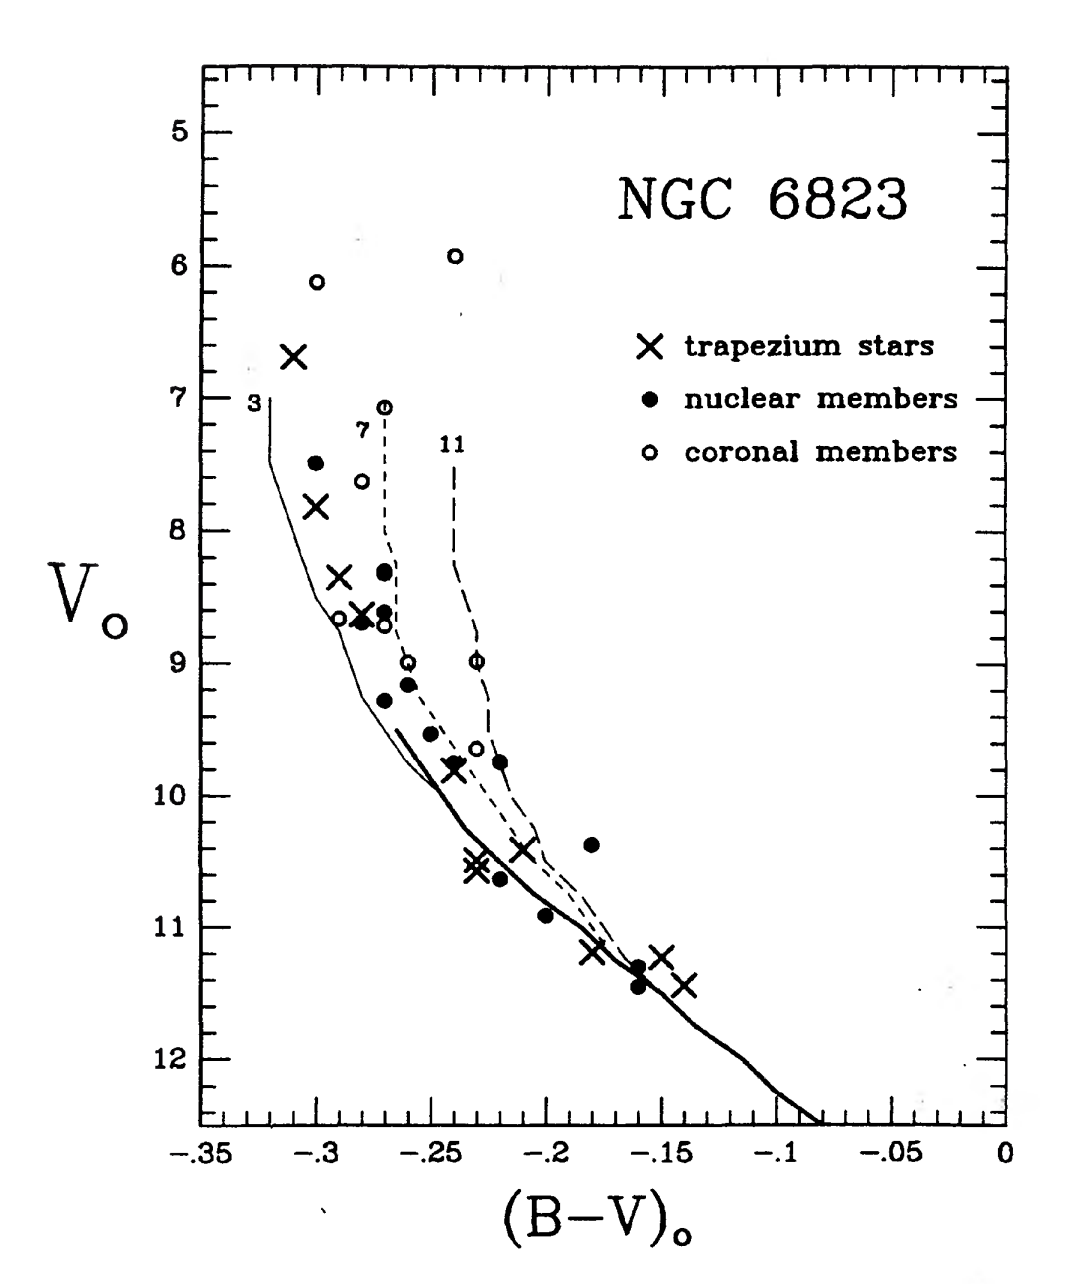

Comparing to the published CMD, mine looks fairly similar in shape, although I'm not entirely sure why I have some stars falling in the bottom right corner of the plot. Quantitatively, my points seem to be shifted towards higher values of V (mine range roughly between 12.5-16.5 while published version ranges between 6-11.5) and shifted towards lower values of B-V (mine somewhere between -2.5-0 while published between -0.3-(-0.15)). These shifted values are probably due to the fact that I didn't de-redden my magnitudes.